In [1]:
! git clone https://github.com/Bhavay-Garg/Lung-Disease-Detection.git

Cloning into 'Lung-Disease-Detection'...
remote: Enumerating objects: 10108, done.
remote: Total 10108 (delta 0), reused 0 (delta 0), pack-reused 10108
Receiving objects: 100% (10108/10108), 1.97 GiB | 18.58 MiB/s, done.
Updating files: 100% (10095/10095), done.


In [1]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(include_top=False, weights='imagenet')

In [2]:
IMG_SIZE = 224

In [3]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


In [4]:
import tensorflow_datasets as tfds

batch_size = 64

builder = tfds.ImageFolder('/content/Lung-Disease-Detection/Dataset')


train_ds=ds = builder.as_dataset(split='train', shuffle_files=True,as_supervised=True)
test_ds=ds = builder.as_dataset(split='test', shuffle_files=True,as_supervised=True)
builder.info

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/content/Lung-Disease-Detection/Dataset',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=2025, num_shards=1>,
        'train': <SplitInfo num_examples=6054, num_shards=1>,
        'val': <SplitInfo num_examples=2016, num_shards=1>,
    },
    citation="""""",
)

In [ ]:
tfds.show_examples(train_ds, builder.info)

In [5]:
size = (IMG_SIZE, IMG_SIZE)
NUM_CLASSES=5
train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, size), label))
test_ds = test_ds.map(lambda image, label: (tf.image.resize(image, size), label))

In [6]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_ds = train_ds.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(input_preprocess)
test_ds = test_ds.batch(batch_size=batch_size, drop_remainder=True)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=5)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 25  
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 5)                4055976   
                                                                 
Total params: 4,055,976
Trainable params: 4,013,953
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/25
94/94 - 110s - loss: 1.7137 - accuracy: 0.4663 - val_loss: 1.9839 - val_accuracy: 0.1971 - 110s/epoch - 1s/step
Epoch 2/25
94/94 - 60s - loss: 0.9229 - accuracy: 0.6182 - val_loss: 2.8159 - val_accuracy: 0.1991 - 60s/epoch - 642ms/st

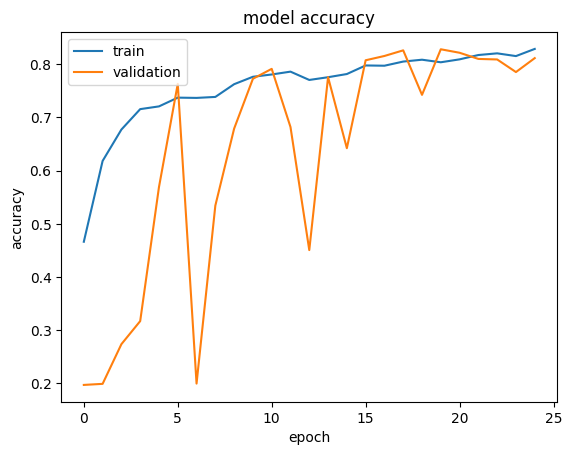

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [10]:
model.save("model")
model.save("model.h5")


In [11]:
import shutil
shutil.make_archive('model', 'zip', 'model')

'/content/model.zip'